In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

import matplotlib
from pcygni_profile import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time
import pickle
import corner

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

from scipy.integrate import quad
def integral(x): 
    return np.sqrt(1-v**2) * 1/(1-v*np.cos(x))*np.sin(x)*np.cos(x)**2 * (3) 

#n_days = np.array([126000, 212400, 298800, 385200])/86400
#n_days = np.array([1.43, 2.42, 3.41, 4.4])
#n_days = np.array([1.43, 2.42, 3.45, 4.4, 5.4])

#beta, doppler = np.loadtxt('doppler_wo_prolate.txt')
#inter = interp1d(beta, doppler)

beta1, doppler1 = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta1, doppler1)

#beta, doppler = np.loadtxt('doppler_incl_temp_40.txt')
#inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    #delta = (1-vphot**2)**(1/2) * 1/(1-vphot)
    #delta = (1-vphot**2)**(-1/2) * (1-vphot)
    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse
    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc


(0.0, 6.0)

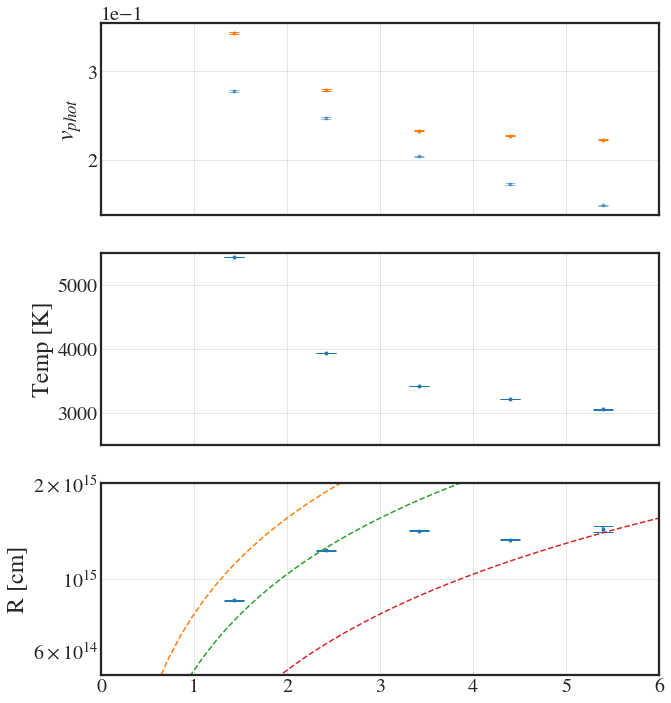

In [2]:
reset_plt(20,24)
n_days = [1.43, 2.424, 3.42, 4.40, 5.40]

#files = ["./data/OB1/OB1_3_peaks_100walkers.pkl", "./data/OB2/OB2_3_peaks_100walkers.pkl",
#         "./data/OB3/OB3_3_peaks_filtered_3.pkl", "./Data/OB4/OB4_3_peaks_filtered.pkl", 
#         "./Data/OB5/OB5_3_filtered_short.pkl" ] 
files = ["./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_with_gaussian.pkl", "./Data/OB4/OB4_3_peaks_filtered.pkl", 
         "./Data/OB5/OB5_3_filtered_short.pkl" ] 

v_phot = []; dv_phot = []; v_max = []; dv_max = []
temp = []; dtemp = []; N = []; dN = []

#n_days = [1.45, 2.45, 3.45, 4.45, 5.45]
for idx, file in enumerate(files):
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    v_phot.append(emcee_res.params['vphot'].value )
    dv_phot.append(emcee_res.params['vphot'].stderr)
    v_max.append(emcee_res.params['vmax'].value )
    dv_max.append(emcee_res.params['vmax'].stderr)
    
    temp.append(emcee_res.params['T'].value )
    dtemp.append(emcee_res.params['T'].stderr)
    N.append(emcee_res.params['N'].value )
    dN.append(emcee_res.params['N'].stderr)
    
fig,ax = plt.subplots(nrows=3, figsize=(10,12), sharex=True)
ax[0].errorbar(n_days, v_phot, yerr=2*np.array(dv_phot), fmt='.', capsize=5, alpha=0.5), ax[0].set_ylabel(r'$v_{phot}$')
ax[0].errorbar(n_days, v_max, yerr =2*np.array(dv_max) , fmt='.', capsize=5)

ax[1].errorbar(n_days, temp, yerr=dtemp, fmt='.', capsize=10), ax[1].set_ylabel('Temp [K]')
ax[1].ticklabel_format(axis='y', style='plain'), ax[1].set_ylim(2500,5500)

v_phot = np.array(v_phot)

from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
dl = cosmo.luminosity_distance(0.00957).to(u.cm).value
R = np.sqrt( np.array(N)*10**7 / (np.pi) ) *dl
dR = np.sqrt( 10**7 / (np.array(N)*np.pi) ) *dl*np.array(dN)

ax[2].errorbar(n_days, R, yerr=dR, fmt='.', capsize=10), ax[2].set_ylabel('R [cm]')
ax[2].set_yscale('log'), ax[2].set_ylim(0.5e15, 2e15) #, ax[1].set_xscale('log')
ax[2].plot( np.linspace(0, 6), np.linspace(0, 6*86400)*3e10*0.3, ls='--' )
ax[2].plot( np.linspace(0, 6), np.linspace(0, 6*86400)*3e10*0.20, ls='--' )
ax[2].plot( np.linspace(0, 6), np.linspace(0, 6*86400)*3e10*0.1, ls='--' )

plt.xlim(0, 6)

In [3]:
v_r = R/n_days/(24*3600*3e10)*inter(v_phot)
dv_r = dR/n_days/(24*3600*3e10)*inter(v_phot)
v_r, dv_r

(array([0.28208976, 0.23410565, 0.18540806, 0.13206512, 0.1143628 ]),
 array([0.00066479, 0.00068967, 0.00042595, 0.00041641, 0.00240138]))

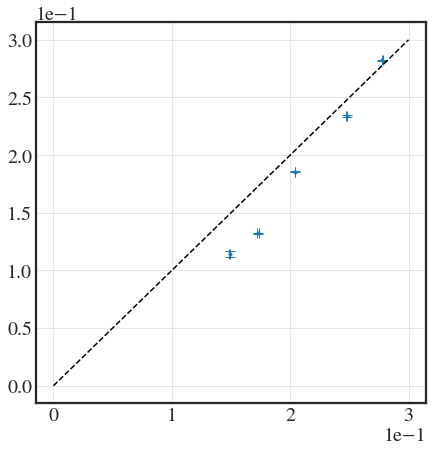

In [4]:
plt.figure(figsize=(7,7))
plt.errorbar(v_phot, v_r, yerr = dv_r, xerr=dv_phot, fmt='.', capsize=5)
plt.plot(np.linspace(0., 0.3), np.linspace(0., 0.3), ls='--', color='k')

In [5]:
import numpy as np

H0_s = np.random.normal(loc=73.03, scale=1.04, size=10000)
z_s  = np.random.normal(loc=0.00957, scale=0.00047, size=10000)

dist = 1/H0_s*3e5*z_s*(1+1.53/2*z_s)

np.mean(dist), np.std(dist)

(39.60516306642178, 2.0546064615816295)

In [6]:
H0_p,dH0_p  = 67.36, 0.54
#H0_s,dH0_s  = 73.03, 1.04
H0_sn  = 73.03; dH0_sn = 1.04
z = 0.00957
0.07/43.3, 0.28/43.3

(0.0016166281755196307, 0.006466512702078523)

Planck 0.003878194947632518 -0.004138768913256229
SNe -0.0333717344719151 -0.04758985844916764


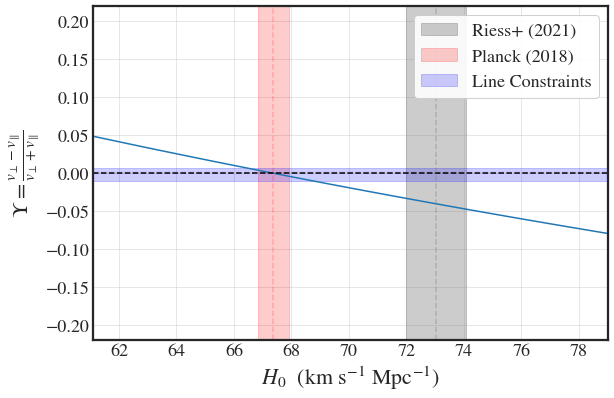

In [10]:
reset_plt(18,22)
plt.figure(figsize=(9,6))
n_days = [1.43, 2.42, 3.42, 4.40, 5.40]
multi = (0.015**2+np.array([0.005, 0.008, 0.008, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration
scale = [0.016, 0.018, 0.016]

#multi = [1.042, 1.042]#[1.0076, 1.0080]#[1.0018, 1.0064]

for i in [0]: 
    for idx, file in enumerate([files[i]]):
        pickle_in = open(file,"rb")
        emcee_res = pickle.load(pickle_in)
        emcee_flatten = emcee_res.flatchain
        
        H0_s1 = np.linspace(60, 80, 100)
        dl_s1 = 1/H0_s1*3e5*z*(1+1.53/2*z)
        
        N_1      = np.median( np.array(emcee_flatten['N'])     )
        v_phot_1 = np.median( np.array(emcee_flatten['vphot']) )
        R_1 = np.sqrt( np.array(N_1)*10**7  ) *(dl_s1*3.086e+24)
        v_sn_1 = R_1/n_days[i]/(24*3600*3e10)/inter(v_phot_1)**2
        upsilon_s_1 = (v_sn_1-v_phot_1)/(v_sn_1+v_phot_1)
        upsilon_s_up  = (multi[i]*v_sn_1-v_phot_1)/(multi[i]*v_sn_1+v_phot_1)
        upsilon_s_low = (1/multi[i]*v_sn_1-v_phot_1)/(1/multi[i]*v_sn_1+v_phot_1)

        plt.plot(H0_s1, upsilon_s_1, ls='-')#, s=1, alpha=0.2)

        #plt.fill_between(H0_s1, upsilon_s_up*(0.0004+0.00957)/0.00957, #upsilon_s_1*multi[i], #*(-0.0004+0.00957)/0.00957, 
        #                        upsilon_s_low*(-0.0004+0.00957)/0.00957, #upsilon_s_1/multi[i], #*(0.0004+0.00957)/0.00957, 
        #                 alpha=0.5, label='Epoch '+str(i+1))#, s=1, alpha=0.2)
        
        #ups_binned = []
        #for h_0 in np.arange(65, 76): 
        #    ups_binned.append(upsilon_s_1[(H0_s1<(h_0+1)) & (H0_s1>(h_0-1))])
        print('Planck',interp1d(H0_s1, upsilon_s_1)(H0_p-dH0_p), interp1d(H0_s1, upsilon_s_1)(H0_p+dH0_p))
        print('SNe',interp1d(H0_s1, upsilon_s_1)(H0_sn-dH0_sn), interp1d(H0_s1, upsilon_s_1)(H0_sn+dH0_sn))

        
        
#plt.ylim(0.83, 1.17), plt.xlim(65, 76)
#plt.ylim(0.7, 1.3), plt.xlim(60, 80)
plt.ylim(-.22, .22), plt.xlim(61.1, 79.)

plt.axhline(0, ls='--', color='k')
plt.ylabel(r'$\Upsilon = \frac{v_\perp - v_{\parallel}}{v_\perp + v_\parallel}$'), plt.xlabel(r'$H_0$  (km s$^{-1}$ Mpc$^{-1}$)')

H0_sn  = 73.03; dH0_sn = 1.04
plt.axvline(H0_sn, ls='--', color='grey', alpha=0.4)
plt.fill_between([H0_sn-dH0_sn, H0_sn+dH0_sn], [-2, -2], [2, 2], color='grey', alpha=0.4, label='Riess+ (2021)' )

H0_p  = 67.36; dH0_p = 0.54
plt.axvline(H0_p, ls='--', color='red', alpha=0.2)
plt.fill_between([H0_p-dH0_p, H0_p+dH0_p], [-2, -2], [2, 2], color='red', alpha=0.2, label='Planck (2018)' )


low = np.array([0.980, 0.994, 0.967, 0.915]) #, 0.92 ])
hig = np.array([1.013, 1.016, 0.992, 0.979])

plt.fill_between([60, 80], [(low[0]-1)/2, (low[0]-1)/2], [(hig[0]-1)/2, (hig[0]-1)/2], color='blue', alpha=0.2, label='Line Constraints' )
#plt.fill_between([60, 80], [(low[1]-1)/2, (low[1]-1)/2], [(hig[1]-1)/2, (hig[1]-1)/2], color='blue', alpha=0.2, label='Line Constraints' )


plt.ticklabel_format(style='plain')
plt.legend(frameon=True, framealpha=0.9, loc=1, fontsize=18)

#sns.despine(trim=True, offset=20)
#plt.grid(False)

plt.tight_layout()
#plt.savefig('Pictures/Assymetry_H0_8.png', dpi=300)

In [11]:
middle = interp1d(upsilon_s_1, H0_s1)(0)
higher = interp1d(upsilon_s_1, (H0_s1+dH0_p)*(0.00047 +0.00957)/0.00957 )((low[0]-1)/2)
lower  = interp1d(upsilon_s_1, (H0_s1-dH0_p)*(-0.00047 +0.00957)/0.00957)((hig[0]-1)/2) 

print('Middle = ', middle, 'p ', higher-middle, 'm ', middle-lower)
print('High   = ', higher )
print('Low    = ', lower )
print('Wrong estimate because every error is additive')
#print('High = '  , interp1d(H0_s1, upsilon_s_up * (0.00047 +0.00957)/0.00957)(H0_p-dH0_p))
#print('Low  = '  , interp1d(H0_s1, upsilon_s_low * (-0.00047+0.00957)/0.00957)(H0_p+dH0_p))

Middle =  67.34031110281403 p  5.300895164119169 m  4.647793731380091
High   =  72.6412062669332
Low    =  62.69251737143394
Wrong estimate because every error is additive


0.09582944242269315
-1.3820307481284404


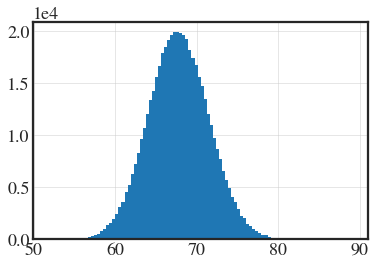

In [16]:
for i in [0]: 
    for idx, file in enumerate([files[i]]):
        pickle_in = open(file,"rb")
        emcee_res = pickle.load(pickle_in)
        emcee_flatten = emcee_res.flatchain
        
vphot = np.array(emcee_flatten['vphot'])*np.random.normal(loc=0.996, scale=scale[idx], size=len(emcee_flatten['vphot']))
z_s = np.random.normal(loc=0.00957, scale=0.00047, size=len(emcee_flatten['vphot']))

dl = lum_dist_arr(np.array(emcee_flatten['N'])*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])), 
         vphot, n_days=n_days[idx])
        
H0 = 1/dl *3e5 * z_s*(1+1.53/2*z_s)

plt.hist(H0, bins=100); 
np.median(H0), np.median(H0)-np.percentile(H0, 15.9), -np.median(H0)+np.percentile(H0, 100-15.9)

print( (np.median(H0)-H0_p)/(dH0_p**2+3.7**2)**(1/2) )
print( (np.median(H0)-H0_sn)/(dH0_sn**2+3.7**2)**(1/2) )

-0.1297514201551123
-1.6014965823339684


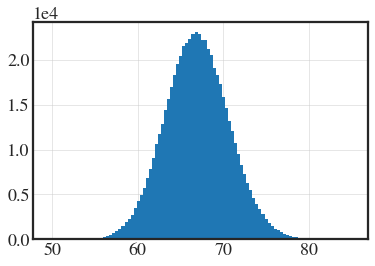

In [17]:
for i in [1]: 
    for idx, file in enumerate([files[i]]):
        pickle_in = open(file,"rb")
        emcee_res = pickle.load(pickle_in)
        emcee_flatten = emcee_res.flatchain
        
vphot = np.array(emcee_flatten['vphot'])*np.random.normal(loc=1.00, scale=scale[1], size=len(emcee_flatten['vphot']))
z_s = np.random.normal(loc=0.00957, scale=0.00047, size=len(emcee_flatten['vphot']))

dl = lum_dist_arr(np.array(emcee_flatten['N'])*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])), 
         vphot, n_days=2.42)
        
H0 = 1/dl *3e5 * z_s*(1+1.53/2*z_s)

plt.hist(H0, bins=100); 
np.median(H0), np.median(H0)-np.percentile(H0, 15.9), -np.median(H0)+np.percentile(H0, 100-15.9)

print( (np.median(H0)-H0_p)/(dH0_p**2+3.7**2)**(1/2) )
print( (np.median(H0)-H0_sn)/(dH0_sn**2+3.7**2)**(1/2) )

67.14474964355676 1.1506480215978172 1.1911592583744124
0.016979193041509657
-0.05756591905534707
-1.5312678801498907


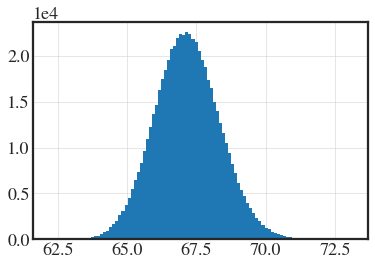

In [23]:
dl = np.random.normal(loc=43.072119026679445, scale=0.752, size=len(emcee_flatten['vphot']))
z_s = np.random.normal(loc=0.00957, scale=0.000001, size=len(emcee_flatten['vphot']))

H0 = 1/dl *3e5 * z_s*(1+1.53/2*z_s)

plt.hist(H0, bins=100); 
print( np.median(H0), np.median(H0)-np.percentile(H0, 15.9), -np.median(H0)+np.percentile(H0, 100-15.9) )
print(1.14/67.141)
print( (np.median(H0)-H0_p)/(dH0_p**2+3.7**2)**(1/2) )
print( (np.median(H0)-H0_sn)/(dH0_sn**2+3.7**2)**(1/2) )

In [64]:
5/68

0.07352941176470588

In [56]:
H0_s1

array([60.        , 60.2020202 , 60.4040404 , 60.60606061, 60.80808081,
       61.01010101, 61.21212121, 61.41414141, 61.61616162, 61.81818182,
       62.02020202, 62.22222222, 62.42424242, 62.62626263, 62.82828283,
       63.03030303, 63.23232323, 63.43434343, 63.63636364, 63.83838384,
       64.04040404, 64.24242424, 64.44444444, 64.64646465, 64.84848485,
       65.05050505, 65.25252525, 65.45454545, 65.65656566, 65.85858586,
       66.06060606, 66.26262626, 66.46464646, 66.66666667, 66.86868687,
       67.07070707, 67.27272727, 67.47474747, 67.67676768, 67.87878788,
       68.08080808, 68.28282828, 68.48484848, 68.68686869, 68.88888889,
       69.09090909, 69.29292929, 69.49494949, 69.6969697 , 69.8989899 ,
       70.1010101 , 70.3030303 , 70.50505051, 70.70707071, 70.90909091,
       71.11111111, 71.31313131, 71.51515152, 71.71717172, 71.91919192,
       72.12121212, 72.32323232, 72.52525253, 72.72727273, 72.92929293,
       73.13131313, 73.33333333, 73.53535354, 73.73737374, 73.93

In [44]:
print('Middle = ', interp1d(H0_s1, upsilon_s_1)(H0_p))
print('High = '  , interp1d(H0_s1, upsilon_s_up * (0.00047 +0.00957)/0.00957)(H0_p-dH0_p))
print('Low  = '  , interp1d(H0_s1, upsilon_s_low * (-0.00047+0.00957)/0.00957)(H0_p+dH0_p))

Middle =  -0.003461388215264139
High =  0.022168515325459118
Low  =  -0.026641710910489592


In [46]:
(0.022+0.026)/2

0.024

In [49]:
print('SN Middle = ', interp1d(H0_s1, upsilon_s_1)(H0_s))
print('High = '  , interp1d(H0_s1, upsilon_s_up * (0.00047 +0.00957)/0.00957)(H0_s-dH0_s))
print('Low  = '  , interp1d(H0_s1, upsilon_s_low * (-0.00047+0.00957)/0.00957)(H0_s+dH0_s))

SN Middle =  -0.04384280536262505
High =  -0.0169190845198205
Low  =  -0.06788431490931383


In [51]:
(interp1d(H0_s1, upsilon_s_up * (0.00047 +0.00957)/0.00957)(H0_s-dH0_s)-interp1d(H0_s1, upsilon_s_low * (-0.00047+0.00957)/0.00957)(H0_s+dH0_s))/2

0.025482615194746667

In [63]:
reset_plt(18,22)
plt.figure(figsize=(7,7))
n_days = [1.43, 2.42, 3.42, 4.40, 5.40]

multi = [1.0076, 1.0080]#[1.0018, 1.0064]

for i in [0,1]: 
    for idx, file in enumerate([files[i]]):
        pickle_in = open(file,"rb")
        emcee_res = pickle.load(pickle_in)
        emcee_flatten = emcee_res.flatchain
        
        H0_s1 = np.linspace(60, 80, 100)
        dl_s1 = 1/H0_s1*3e5*z*(1+1.53/2*z)
        
        N_1      = np.array(emcee_flatten['N'])
        v_phot_1 = np.array(emcee_flatten['vphot'])
        R_1 = np.sqrt( np.array(N_1)*10**7  ) *(dl_s1*3.086e+24)
        v_sn_1 = R_1/n_days[i]/(24*3600*3e10)/inter(v_phot_1)**2
        upsilon_s_1 = (v_sn_1-v_phot_1)/(v_sn_1+v_phot_1)
        #upsilon_s_up  = (multi[i]*v_sn_1-v_phot_1)/(multi[i]*v_sn_1+v_phot_1)
        #upsilon_s_low = (1/multi[i]*v_sn_1-v_phot_1)/(1/multi[i]*v_sn_1+v_phot_1)

        #plt.plot(H0_s1, upsilon_s_1, ls='-')#, s=1, alpha=0.2)

        #plt.fill_between(H0_s1, upsilon_s_up*(0.0004+0.00957)/0.00957, #upsilon_s_1*multi[i], #*(-0.0004+0.00957)/0.00957, 
        #                        upsilon_s_low*(-0.0004+0.00957)/0.00957, #upsilon_s_1/multi[i], #*(0.0004+0.00957)/0.00957, 
        #                 alpha=0.5, label='Epoch '+str(i+1))#, s=1, alpha=0.2)

        #ups_binned = []
        #for h_0 in np.arange(65, 76): 
        #    ups_binned.append(upsilon_s_1[(H0_s1<(h_0+1)) & (H0_s1>(h_0-1))])
        #print('Planck',interp1d(H0_s1, upsilon_s_1)(H0_p-dH0_p), interp1d(H0_s1, upsilon_s_1)(H0_p+dH0_p))
        #print('SNe',interp1d(H0_s1, upsilon_s_1)(H0_sn-dH0_sn), interp1d(H0_s1, upsilon_s_1)(H0_sn+dH0_sn))



ValueError: operands could not be broadcast together with shapes (1000000,) (100,) 

<Figure size 504x504 with 0 Axes>

Planck 1.0000620922513277 0.9841545295831585
SNe 0.9282422113594709 0.9021756553904117
Planck 1.005703311828237 0.9897060166778151
SNe 0.9334783043735022 0.9072647103685301


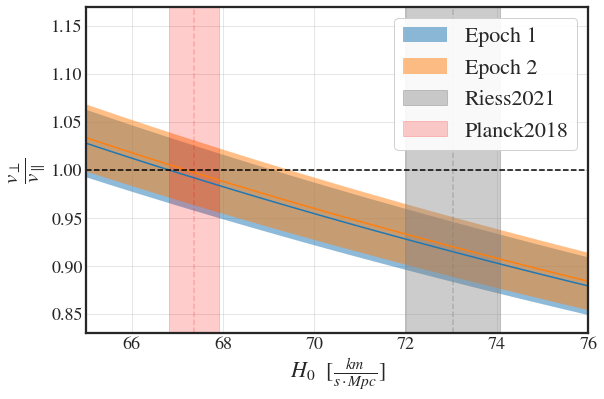

In [106]:
reset_plt(18,22)
plt.figure(figsize=(9,6))
n_days = [1.43, 2.42, 3.42, 4.40, 5.40]

multi = [1.0076, 1.0080]#[1.0018, 1.0064]

for i in [0,1]: 
    for idx, file in enumerate([files[i]]):
        pickle_in = open(file,"rb")
        emcee_res = pickle.load(pickle_in)
        emcee_flatten = emcee_res.flatchain
        
        H0_s1 = np.linspace(60, 80, 100)
        dl_s1 = 1/H0_s1*3e5*z*(1+1.53/2*z)
        
        N_1      = np.median( np.array(emcee_flatten['N'])     )
        v_phot_1 = np.median( np.array(emcee_flatten['vphot']) )
        R_1 = np.sqrt( np.array(N_1)*10**7  ) *(dl_s1*3.086e+24)
        v_sn_1 = R_1/n_days[i]/(24*3600*3e10)/inter(v_phot_1)**2
        upsilon_s_1 = (v_sn_1)/(v_phot_1)

        plt.plot(H0_s1, upsilon_s_1, ls='-')#, s=1, alpha=0.2)

        plt.fill_between(H0_s1, upsilon_s_1*multi[i]*(-0.0004+0.00957)/0.00957, 
                                upsilon_s_1/multi[i]* (0.0004+0.00957)/0.00957, 
                         alpha=0.5, label='Epoch '+str(i+1))#, s=1, alpha=0.2)

        #ups_binned = []
        #for h_0 in np.arange(65, 76): 
        #    ups_binned.append(upsilon_s_1[(H0_s1<(h_0+1)) & (H0_s1>(h_0-1))])
        print('Planck',interp1d(H0_s1, upsilon_s_1)(H0_p-dH0_p), interp1d(H0_s1, upsilon_s_1)(H0_p+dH0_p))
        print('SNe',interp1d(H0_s1, upsilon_s_1)(H0_sn-dH0_sn), interp1d(H0_s1, upsilon_s_1)(H0_sn+dH0_sn))

plt.ylim(0.83, 1.17), plt.xlim(65, 76)#, plt.yscale('l')
#lt.ylim(0.7, 1.3), plt.xlim(60, 80)
#plt.ylim(0.83-1, 1.17-1), plt.xlim(65, 76)

plt.axhline(1, ls='--', color='k')
plt.ylabel(r'$\frac{v_\perp}{v_\parallel}$', fontsize=30), plt.xlabel(r'$H_0$  $[ \frac{km}{s \cdot Mpc}]$')

H0_sn  = 73.03; dH0_sn = 1.04
plt.axvline(H0_sn, ls='--', color='grey', alpha=0.4)
plt.fill_between([H0_sn-dH0_sn, H0_sn+dH0_sn], [-2, -2], [2, 2], color='grey', alpha=0.4, label='Riess2021' )

H0_p  = 67.36; dH0_p = 0.54
plt.axvline(H0_p, ls='--', color='red', alpha=0.2)
plt.fill_between([H0_p-dH0_p, H0_p+dH0_p], [-2, -2], [2, 2], color='red', alpha=0.2, label='Planck2018' )

plt.legend(frameon=True, framealpha=0.9, loc=1)
#plt.savefig('Pictures/Assymetry_H0_6.png', dpi=300)

((-0.1, 0.1), (65.0, 76.0))

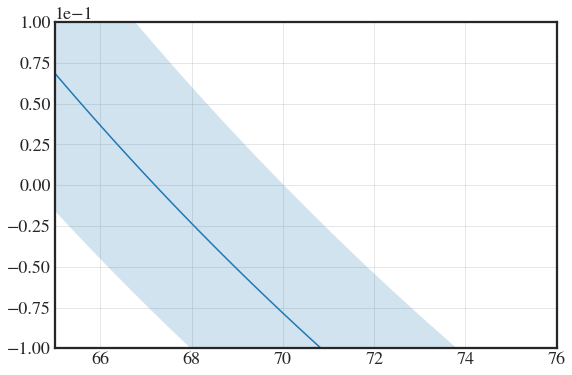

In [100]:
plt.figure(figsize=(9,6))

plt.plot(H0_s1, upsilon_s_1**2-1)
plt.fill_between(H0_s1, (upsilon_s_1*1.042)**2-1, (upsilon_s_1/1.042)**2-1, alpha=0.2)
plt.ylim(-.1, .1), plt.xlim(65, 76)

In [68]:
interp1d(H0_s1, upsilon_s_1)(H0_p-dH0_p), interp1d(H0_s1, upsilon_s_1)(H0_p+dH0_p)

(array(1.00006209), array(0.98415453))

In [69]:
print('Middle = ', interp1d(H0_s1, upsilon_s_1)(H0_p))
print('High = '  , interp1d(H0_s1, upsilon_s_1 * (0.0004 +0.00957)/0.00957)(H0_p-dH0_p))
print('Low  = '  , interp1d(H0_s1, upsilon_s_1 * (-0.0004+0.00957)/0.00957)(H0_p+dH0_p))

Middle =  0.992045494732934
High =  1.041861970715333
Low  =  0.943019544020644


In [73]:
print('Middle = ', interp1d(H0_s1, upsilon_s_1)(H0_s))
print('High = '  , interp1d(H0_s1, upsilon_s_1 * (0.0004 +0.00957)/0.00957)(H0_s-dH0_s))
print('Low  = '  , interp1d(H0_s1, upsilon_s_1 * (-0.0004+0.00957)/0.00957)(H0_s+dH0_s))

Middle =  0.9201850105047321
High =  0.9724951614006078
Low  =  0.8693435103531266


In [61]:
((0.0004/0.00957)**2+((multi[0]-1))**2)**(1/2), 0.0004/0.00957

(0.04248261857447524, 0.04179728317659352)

(Text(0, 0.5, '$\\Upsilon$'),
 Text(0.5, 0, '$H_0$  $[ \\frac{km}{s \\cdot Mpc}]$'))

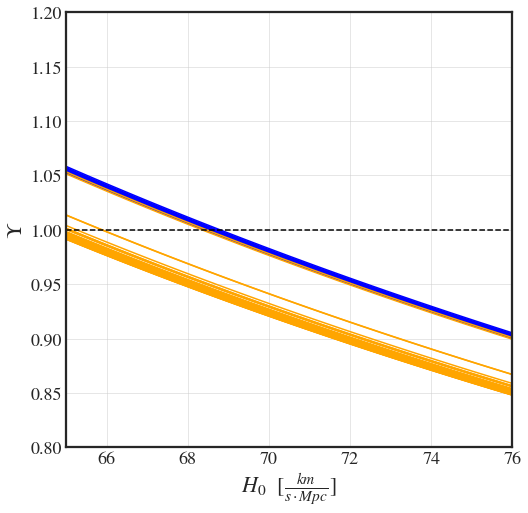

In [155]:

plt.figure(figsize=(8,8))
color=['blue', 'orange']
for i in [0,1]: 
    for idx, file in enumerate([files[i]]):
        pickle_in = open(file,"rb")
        emcee_res = pickle.load(pickle_in)
        emcee_flatten = emcee_res.flatchain
        
        for j in range(100):
            idx2 = np.random.randint(len(np.array(emcee_flatten['N']) ))

            H0_s1 = np.linspace(65, 76, 100)
            dl_s1 = 1/H0_s1*3e5*z*(1+1.53/2*z)
        
            N_1      = np.array(emcee_flatten['N'])[idx2]   
            v_phot_1 = np.array(emcee_flatten['vphot'])[idx2] 
            R_1 = np.sqrt( np.array(N_1)*10**7 / (np.pi) ) *(dl_s1*3.086e+24)
            v_sn_1 = R_1/n_days[i]/(24*3600*3e10)*inter(v_phot_1)
            upsilon_s_1 = v_sn_1/v_phot_1

            plt.plot(H0_s1, upsilon_s_1, color=color[i])#, s=1, alpha=0.2)
        #ups_binned = []
        #for h_0 in np.arange(65, 76): 
        #    ups_binned.append(upsilon_s_1[(H0_s1<(h_0+1)) & (H0_s1>(h_0-1))])
        

plt.ylim(0.8, 1.2), plt.xlim(65, 76)
plt.axhline(1, ls='--', color='k')
plt.ylabel(r'$\Upsilon$'), plt.xlabel(r'$H_0$  $[ \frac{km}{s \cdot Mpc}]$')

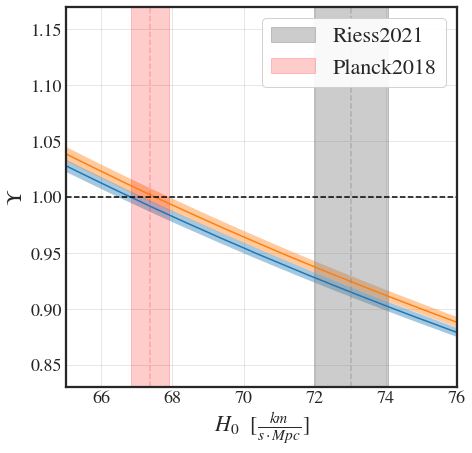

In [62]:
n_days = [1.43, 2.42, 3.42, 4.40, 5.40]

plt.figure(figsize=(7,7))
dh0 = 0.5
for i in [0,1]: 
    for idx, file in enumerate([files[i]]):
        pickle_in = open(file,"rb")
        emcee_res = pickle.load(pickle_in)
        emcee_flatten = emcee_res.flatchain
        
        N_1 = np.array(emcee_flatten['N'])
        v_phot_1 = np.array(emcee_flatten['vphot'])

        H0_s1 = np.random.uniform(low=64.5, high=76.5, size=np.shape(N_1))
        #H0_s1 = np.random.normal(loc=H0_sn, scale=dH0_sn, size=np.shape(N_1))
        dl_s1 = 1/H0_s1*3e5*z*(1+1.53/2*z)
        R_1 = np.sqrt( np.array(N_1)*10**7  ) *(dl_s1*3.086e+24)
        v_sn_1 = R_1/n_days[i]/(24*3600*3e10)/inter(v_phot_1)**2

        upsilon_s_1 = v_sn_1/v_phot_1
        
        ups_mean = []; ups_low=[]; ups_high=[];
        for h_0 in np.linspace(65, 76, 40): 
            ups_mean.append(np.median(upsilon_s_1[(H0_s1<(h_0+dh0)) & (H0_s1>(h_0-dh0))]) )
            ups_low.append( np.percentile(upsilon_s_1[(H0_s1<(h_0+dh0)) & (H0_s1>(h_0-dh0))], 15.9    ) )
            ups_high.append(np.percentile(upsilon_s_1[(H0_s1<(h_0+dh0)) & (H0_s1>(h_0-dh0))], 100-16) )
        
        plt.plot(np.linspace(65, 76, 40), ups_mean)
        plt.fill_between(np.linspace(65, 76, 40), ups_low, ups_high, alpha=0.4)
        #plt.scatter(H0_s1, upsilon_s_1, s=1, alpha=0.2)

#plt.ylim(0.8, 1.2), plt.xlim(65, 76), plt.axhline(1, ls='--', color='k')
#plt.ylabel(r'$\Upsilon$'), plt.xlabel(r'$H_0$  $[ \frac{km}{s \cdot Mpc}]$')


plt.ylim(0.83, 1.17), plt.xlim(65, 76)
#plt.ylim(0.7, 1.3), plt.xlim(60, 80)
plt.axhline(1, ls='--', color='k')
plt.ylabel(r'$\Upsilon$'), plt.xlabel(r'$H_0$  $[ \frac{km}{s \cdot Mpc}]$')

H0_sn  = 73.03; dH0_sn = 1.04
plt.axvline(H0_sn, ls='--', color='grey', alpha=0.4)
plt.fill_between([H0_sn-dH0_sn, H0_sn+dH0_sn], [0, 0], [2, 2], color='grey', alpha=0.4, label='Riess2021' )

H0_p  = 67.36; dH0_p = 0.54
plt.axvline(H0_p, ls='--', color='red', alpha=0.2)
plt.fill_between([H0_p-dH0_p, H0_p+dH0_p], [0, 0], [2, 2], color='red', alpha=0.2, label='Planck2018' )

plt.legend(frameon=True, framealpha=0.9)
#plt.savefig('Pictures/Assymetry_H0_4.png', dpi=300)

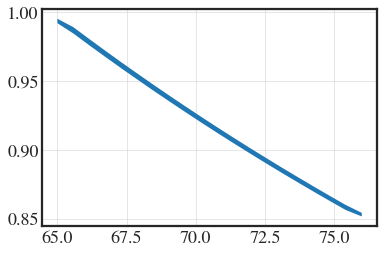

In [166]:
plt.fill_between(np.linspace(65, 76, 20), ups_low, ups_high)

In [169]:
ups_low, ups_high

([0.9921155081075321,
  0.9845890942100411,
  0.9760615625695279,
  0.9675824949912845,
  0.9592724445602219,
  0.951070173620036,
  0.9430648847811913,
  0.9351617240520329,
  0.9274090073356605,
  0.919754756947934,
  0.9122434395263763,
  0.9048625044244739,
  0.8975778962798976,
  0.8904279339619512,
  0.8833689467418653,
  0.8764492995976922,
  0.8696443448053783,
  0.8628984235136375,
  0.8562897304601491,
  0.8516333416483282],
 [0.9953477023483105,
  0.989226693123058,
  0.9805285296546425,
  0.9720690883563889,
  0.9636758347135805,
  0.9554524494507055,
  0.9473463352262395,
  0.9394098093245007,
  0.9315466573246078,
  0.9238767194587952,
  0.9162925069029635,
  0.9088714944774247,
  0.9015397896078875,
  0.8943458405422391,
  0.8872374992901201,
  0.880251829923946,
  0.8734159865347915,
  0.8666115517143247,
  0.8599615885556546,
  0.8542329479267468])

(Text(0, 0.5, '$\\Upsilon$'),
 Text(0.5, 0, '$H_0$  $[ \\frac{km}{s \\cdot Mpc}]$'))

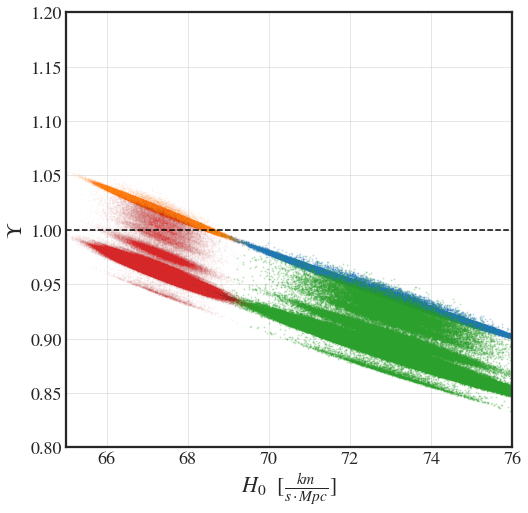

In [129]:
plt.figure(figsize=(8,8))

for i in [0,1]: 
    for idx, file in enumerate([files[i]]):
        pickle_in = open(file,"rb")
        emcee_res = pickle.load(pickle_in)
        emcee_flatten = emcee_res.flatchain
        
        N_1 = np.array(emcee_flatten['N'])
        v_phot_1 = np.array(emcee_flatten['vphot'])

        #H0_s1 = np.random.uniform(low=65, high=76, size=np.shape(N_1))
        H0_s1 = np.random.normal(loc=H0_sn, scale=dH0_sn, size=np.shape(N_1))
        dl_s1 = 1/H0_s1*3e5*z*(1+1.53/2*z)
        R_1 = np.sqrt( np.array(N_1)*10**7 / (np.pi) ) *(dl_s1*3.086e+24)
        v_sn_1 = R_1/n_days[i]/(24*3600*3e10)*inter(v_phot_1)

        upsilon_s_1 = v_sn_1/v_phot_1
        plt.scatter(H0_s1, upsilon_s_1, s=1, alpha=0.2)
    
        
        H0_s1 = np.random.normal(loc=67.36, scale=0.54, size=np.shape(N_1))
        dl_s1 = 1/H0_s1*3e5*z*(1+1.53/2*z)
        R_1 = np.sqrt( np.array(N_1)*10**7 / (np.pi) ) *(dl_s1*3.086e+24)
        v_sn_1 = R_1/n_days[i]/(24*3600*3e10)*inter(v_phot_1)

        upsilon_s_2 = v_sn_1/v_phot_1
        plt.scatter(H0_s1, upsilon_s_2, s=1, alpha=0.02)

plt.ylim(0.8, 1.2), plt.xlim(65, 76)
plt.axhline(1, ls='--', color='k')
plt.ylabel(r'$\Upsilon$'), plt.xlabel(r'$H_0$  $[ \frac{km}{s \cdot Mpc}]$')